In [1]:
#IMPORT LIBARARIES

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sklearn
from datetime import datetime
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import norm, skew
%matplotlib inline

In [2]:
#Read the data file
df = pd.read_csv('./clean_data_after_eda.csv')
#Converting date to standard datetime
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')


In [3]:
#Converting date to standard datetime
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"],format='%Y-%m-%d')
price_df.head()


,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [4]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()
# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()
# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1','price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'),on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] -diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] -diff['price_off_peak_fix']
diff = diff[['id','offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [43]:
monthly_price_by_id

,id,price_date,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,40.565969
1,0002203ffbb812588b632b9e628cc38d,2015-02-01,0.126098,40.565969
2,0002203ffbb812588b632b9e628cc38d,2015-03-01,0.128067,40.728885
3,0002203ffbb812588b632b9e628cc38d,2015-04-01,0.128067,40.728885
4,0002203ffbb812588b632b9e628cc38d,2015-05-01,0.128067,40.728885
...,...,...,...,...
192997,ffff7fa066f1fb305ae285bb03bf325a,2015-08-01,0.119916,40.728885
192998,ffff7fa066f1fb305ae285bb03bf325a,2015-09-01,0.119916,40.728885
192999,ffff7fa066f1fb305ae285bb03bf325a,2015-10-01,0.119916,40.728885
193000,ffff7fa066f1fb305ae285bb03bf325a,2015-11-01,0.119916,40.728885


In [5]:
df = pd.merge(df, diff, on='id')
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,price_mid_peak_fix_y,year_y,month_y,day_y,price_off_peak_y,price_peak_y,price_mid_peak_y,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,44.235794,0.0,3.5,0.0,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.000000,0.0,3.5,0.0,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.000000,0.0,3.5,0.0,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,0.000000,0.0,3.5,0.0,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,0.000000,0.0,3.5,0.0,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916


1.4 Average price changes across periods
We can now enhance the feature that our colleague made by calculating the average price changes
across individual periods, instead of the entire year.

In [6]:
# Aggregate average prices per period by company
mean_prices = price_df.groupby(['id']).agg({
'price_off_peak_var': 'mean',
'price_peak_var': 'mean',
'price_mid_peak_var': 'mean',
'price_off_peak_fix': 'mean',
'price_peak_fix': 'mean',
'price_mid_peak_fix': 'mean'
}).reset_index()

In [7]:
# Calculate the mean difference between consecutive periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix']- mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']



In [8]:
columns = [
'id',
'off_peak_peak_var_mean_diff',
'peak_mid_peak_var_mean_diff',
'off_peak_mid_peak_var_mean_diff',
'off_peak_peak_fix_mean_diff',
'peak_mid_peak_fix_mean_diff',
'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()


,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,price_mid_peak_y,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,4.423670e+01,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.000000e+00,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,0.000000e+00,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,4.860000e-10,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893


This feature may be useful because it adds more granularity to the existing feature that my colleague
found to be useful. Instead of looking at differences across an entire year, we have now created
features that look at mean average price differences across different time periods (off_peak, peak,
mid_peak). The dec-jan feature may reveal macro patterns that occur over an entire year, whereas
inter-time-period features may reveal patterns on a micro scale between months.

1.5 Max price changes across periods and months
Another way we can enhance the feature from our colleague is to look at the maximum change in
prices across periods and months.

In [9]:
# Aggregate average prices per period by company
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
'price_off_peak_var': 'mean',
'price_peak_var': 'mean',
'price_mid_peak_var': 'mean',
'price_off_peak_fix': 'mean',
'price_peak_fix': 'mean',
'price_mid_peak_fix': 'mean'
}).reset_index()


In [10]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']

mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [11]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
'off_peak_peak_var_mean_diff': 'max',
'peak_mid_peak_var_mean_diff': 'max',
'off_peak_mid_peak_var_mean_diff': 'max',
'off_peak_peak_fix_mean_diff': 'max',
'peak_mid_peak_fix_mean_diff': 'max',
'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
columns={
'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff','off_peak_mid_peak_var_mean_diff':'off_peak_mid_peak_var_max_monthly_diff',
'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
'off_peak_mid_peak_fix_mean_diff':'off_peak_mid_peak_fix_max_monthly_diff'
}
)


In [12]:
columns = [
'id',
'off_peak_peak_var_max_monthly_diff',
'peak_mid_peak_var_max_monthly_diff',
'off_peak_mid_peak_var_max_monthly_diff',
'off_peak_peak_fix_max_monthly_diff',
'peak_mid_peak_fix_max_monthly_diff',
'off_peak_mid_peak_fix_max_monthly_diff'
]


In [13]:
df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733


I thought that calculating the maximum price change between months and time periods would be
a good feature to create because I was trying to think from the perspective of a PowerCo client. As
a Utilities customer, there is nothing more annoying than sudden price changes between months,
and a large increase in prices within a short time span would be an influencing factor in causing
me to look at other utilities providers for a better deal. Since we are trying to predict churn for
this use case, I thought this would be an interesting feature to include.


1.6 (BONUS) Further feature engineering
This section covers extra feature engineering that you may have thought of, as well as different ways
you can transform your data to account for some of its statistical properties that we saw before,
such as skewness.
1.6.1 Tenure
How long a company has been a client of PowerCo.

In [14]:
df['tenure'] = ((df['date_end'] - df['date_activ'])/ np.timedelta64(1, 'Y')). astype(int)
df.groupby(['tenure']).agg({'churn': 'mean'}).sort_values(by='churn',ascending=False)

,churn
tenure,
3,0.143713
2,0.133080
4,0.125756
13,0.095238
5,0.085425
12,0.083333
6,0.080713
7,0.073394
11,0.063584


We can see that companies who have only been a client for 4 or less months are much more likely
to churn compared to companies that have been a client for longer. Interestingly, the difference
between 4 and 5 months is about 4%, which represents a large jump in likelihood for a customer to
churn compared to the other differences between ordered tenure values. Perhaps this reveals that
getting a customer to over 4 months tenure is actually a large milestone with respect to keeping
them as a long term customer.
This is an interesting feature to keep for modelling because clearly how long you’ve been a client,
has a influence on the chance of a client churning.
1.6.2 Transforming dates into months
• months_activ = Number of months active until reference date (Jan 2016)
• months_to_end = Number of months of the contract left until reference date (Jan 2016)
• months_modif_prod = Number of months since last modification until reference date (Jan
2016)
• months_renewal = Number of months since last renewal until reference date (Jan 2016)


In [15]:
def convert_months(reference_date, df, column):
#Input a column with timedeltas and return months

    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months


In [16]:
# Create reference date
reference_date = datetime(2016, 1, 1)
# Create columns
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')


Dates as a datetime object are not useful for a predictive model, so we needed to use the datetimes
to create some other features that may hold some predictive power.
Using intuition, you could assume that a client who has been an active client of PowerCo for a
longer amount of time may have more loyalty to the brand and is more likely to stay. Whereas a
newer client may be more volatile. Hence the addition of the months_activ feature.
As well as this, if we think from the perspective of a client with PowerCo, if you’re coming toward
the end of your contract with PowerCo your thoughts could go a few ways. You could be looking
for better deals for when your contract ends, or you might want to see out your contract and
sign another one. One the other hand if you’ve only just joined, you may have a period where
you’re allowed to leave if you’re not satisfied. Furthermore, if you’re in the middle of your contract,
their may be charges if you wanted to leave, deterring clients from churning mid-way through their
agreement. So, I think months_to_end will be an interesting feature because it may reveal patterns
and behaviours about timing of churn.
My belief is that if a client has made recent updates to their contract, they are more likely to
be satisfied or at least they have received a level of customer service to update or change their
existing services. I believe this to be a positive sign, they are an engaged customer, and so I believe
months_modif_prod will be an interesting feature to include because it shows the degree of how
‘engaged’ a client is with PowerCo.
Finally the number of months since a client last renewed a contract I believe will be an interesting
feature because once again, it shows the degree to which that client is engaged. It also goes a step
further than just engagement, it shows a level of commitment if a client renews their contract. For
this reason, I believe months_renewal will be a good feature to include.

In [17]:
# We no longer need the datetime columns that we used for feature engineering,so we can drop them
remove = [
'date_activ',
'date_end',
'date_modif_prod',
'date_renewal'
]
df = df.drop(columns=remove)
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,...,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,...,0.085483,0.146033,44.266930,8.145775,44.26693,3,30,5,2,6
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,...,0.085483,0.151367,44.444710,0.000000,44.44471,7,76,7,76,4
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,...,0.089162,0.172468,44.444710,0.000000,44.44471,6,68,3,68,8
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,...,0.000000,0.153133,44.444710,0.000000,44.44471,6,69,2,69,9
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,...,0.033743,0.055866,16.291555,8.145775,24.43733,6,71,2,71,9


In [18]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})


,churn
has_gas,
0,0.100544
1,0.081856


1.6.4 Transforming categorical data
A predictive model cannot accept categorical or string values, hence as a data scientist you need to
encode categorical features into numerical representations in the most compact and discriminative
way possible.
The simplest method is to map each category to an integer (label encoding), however this is not
always appropriate beecause it then introduces the concept of an order into a feature which may
not inherently be present 0 < 1 < 2 < 3 ...
Another way to encode categorical features is to use dummy variables AKA one hot encoding.
This create a new feature for every unique value of a categorical column, and fills this column with
either a 1 or a 0 to indicate that this company does or does not belong to this category.


In [19]:
# Transform into categorical type
df['channel_sales'] = df['channel_sales'].astype('category')
# Let's see how many categories are within this column
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

We have 8 categories, so we will create 8 dummy variables from this column. However, as you can
see the last 3 categories in the output above, show that they only have 11, 3 and 2 occurrences
respectively. Considering that our dataset has about 14000 rows, this means that these dummy
variables will be almost entirely 0 and so will not add much predictive power to the model at all
(since they’re almost entirely a constant value and provide very little).
For this reason, we will drop these 3 dummy variables.

In [20]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds','channel_epumfxlbckeskwekxbiuasklxalciiuu','channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()


,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,...,3,30,5,2,6,0,0,1,0,0
1,1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,...,7,76,7,76,4,1,0,0,0,0
2,2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,...,6,68,3,68,8,0,0,1,0,0
3,3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,...,6,69,2,69,9,0,0,0,1,0
4,4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,...,6,71,2,71,9,1,0,0,0,0


In [21]:
# Transform into categorical type
df['origin_up'] = df['origin_up'].astype('category')
# Let's see how many categories are within this column
df['origin_up'].value_counts()


lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

Similar to channel_sales the last 3 categories in the output above show very low frequency, so we
will remove these from the features after creating dummy variables.

In [22]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING','origin_up_usapbepcfoloekilkwsdiboslwaxobdp','origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()


,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,...,2,6,0,0,1,0,0,0,0,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,...,76,4,1,0,0,0,0,1,0,0
2,2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,...,68,8,0,0,1,0,0,1,0,0
3,3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,...,69,9,0,0,0,1,0,1,0,0
4,4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,...,71,9,1,0,0,0,0,1,0,0


1.6.5 Transforming numerical data
In the previous exercise we saw that some variables were highly skewed. The reason why we need to
treat skewness is because some predictive models have inherent assumptions about the distribution
of the features that are being supplied to it. Such models are called parametric models, and they
typically assume that all variables are both independent and normally distributed.
Skewness isn’t always a bad thing, but as a rule of thumb it is always good practice to treat highly
skewed variables because of the reason stated above, but also as it can improve the speed at which
predictive models are able to converge to its best solution.
There are many ways that you can treat skewed variables. You can apply transformations such as:
- Square root - Cubic root - Logarithm
to a continuous numeric column and you will notice the distribution changes. For this use case we
will use the ‘Logarithm’ transformation for the positively skewed features.
Note: We cannot apply log to a value of 0, so we will add a constant of 1 to all the values
First I want to see the statistics of the skewed features, so that we can compare before and after
transformation

In [23]:
skewed = [
'cons_12m',
'cons_gas_12m',
'cons_last_month',
'forecast_cons_12m',
'forecast_cons_year',
'forecast_discount_energy',
'forecast_meter_rent_12m',
'forecast_price_energy_off_peak',
'forecast_price_energy_peak',
'forecast_price_pow_off_peak'
]
df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056
std,5.734653e+05,1.629731e+05,64364.196422,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411550e+04,0.000000e+00,792.500000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378
75%,4.076375e+04,0.000000e+00,3383.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


We can see that the standard deviation for most of these features is quite high.

In [24]:
# Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)


In [25]:
df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,4.223939,0.779244,2.264646,2.962177,1.784610,0.966726,1.517203,0.137283,0.050491,43.130056
std,0.884515,1.717071,1.769305,0.683592,1.584986,5.108289,0.571481,0.024623,0.049037,4.485988
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.754023,0.000000,0.000000,2.695477,0.000000,0.000000,1.235023,0.116340,0.000000,40.606701
50%,4.149727,0.000000,2.899547,3.046836,2.498311,0.000000,1.296555,0.143166,0.084138,44.311378
75%,4.610285,0.000000,3.529430,3.380716,3.242231,0.000000,2.120673,0.146348,0.098837,44.311378
max,6.792889,6.618528,5.887169,4.918575,5.243970,30.000000,2.778376,0.273963,0.195975,59.266378


Now we can see that for the majority of the features, their standard deviation is much lower after
transformation. This is a good thing, it shows that these features are more stable and predictable
now.
Let’s quickly check the distributions of some of these features too.

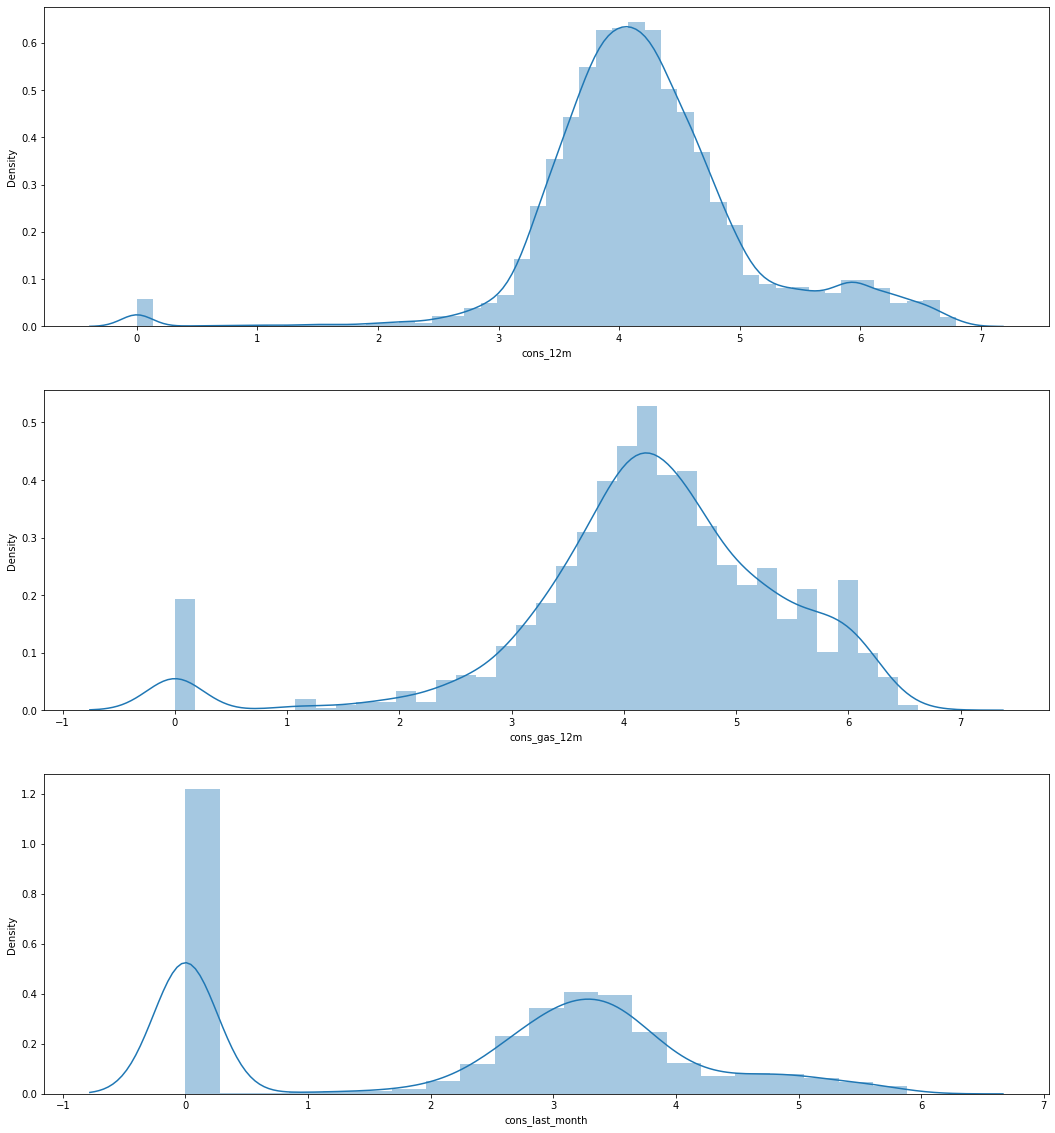

In [26]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()


1.6.6 Correlations
In terms of creating new features and transforming existing ones, it is very much a trial and error
situation that requires iteration. Once we train a predictive model we can see which features work
and don’t work, we will also know how predictive this set of features is. Based on this, we can come
back to feature engineering to enhance our model.
For now, we will leave feature engineering at this point. Another thing that is always useful to look
at is how correlated all of the features are within your dataset.
This is important because it reveals the linear relationships between features. We want features to
correlate with churn, as this will indicate that they are good predictors of it. However features that
have a very high correlation can sometimes be suspicious. This is because 2 columns that have high
correlation indicates that they may share a lot of the same information. One of the assumptions
of any parametric predictive model (as stated earlier) is that all features must be independent.
For features to be independent, this means that each feature must have absolutely no dependence
on any other feature. If two features are highly correlated and share similar information, this breaks
this assumption.
Ideally, you want a set of features that have 0 correlation with all of the independent variables
(all features except our target variable) and a high correlation with the target variable (churn).
However, this is very rarely the case and it is common to have a small degree of correlation between
independent features.
So now let’s look at how all the features within the model are correlated.

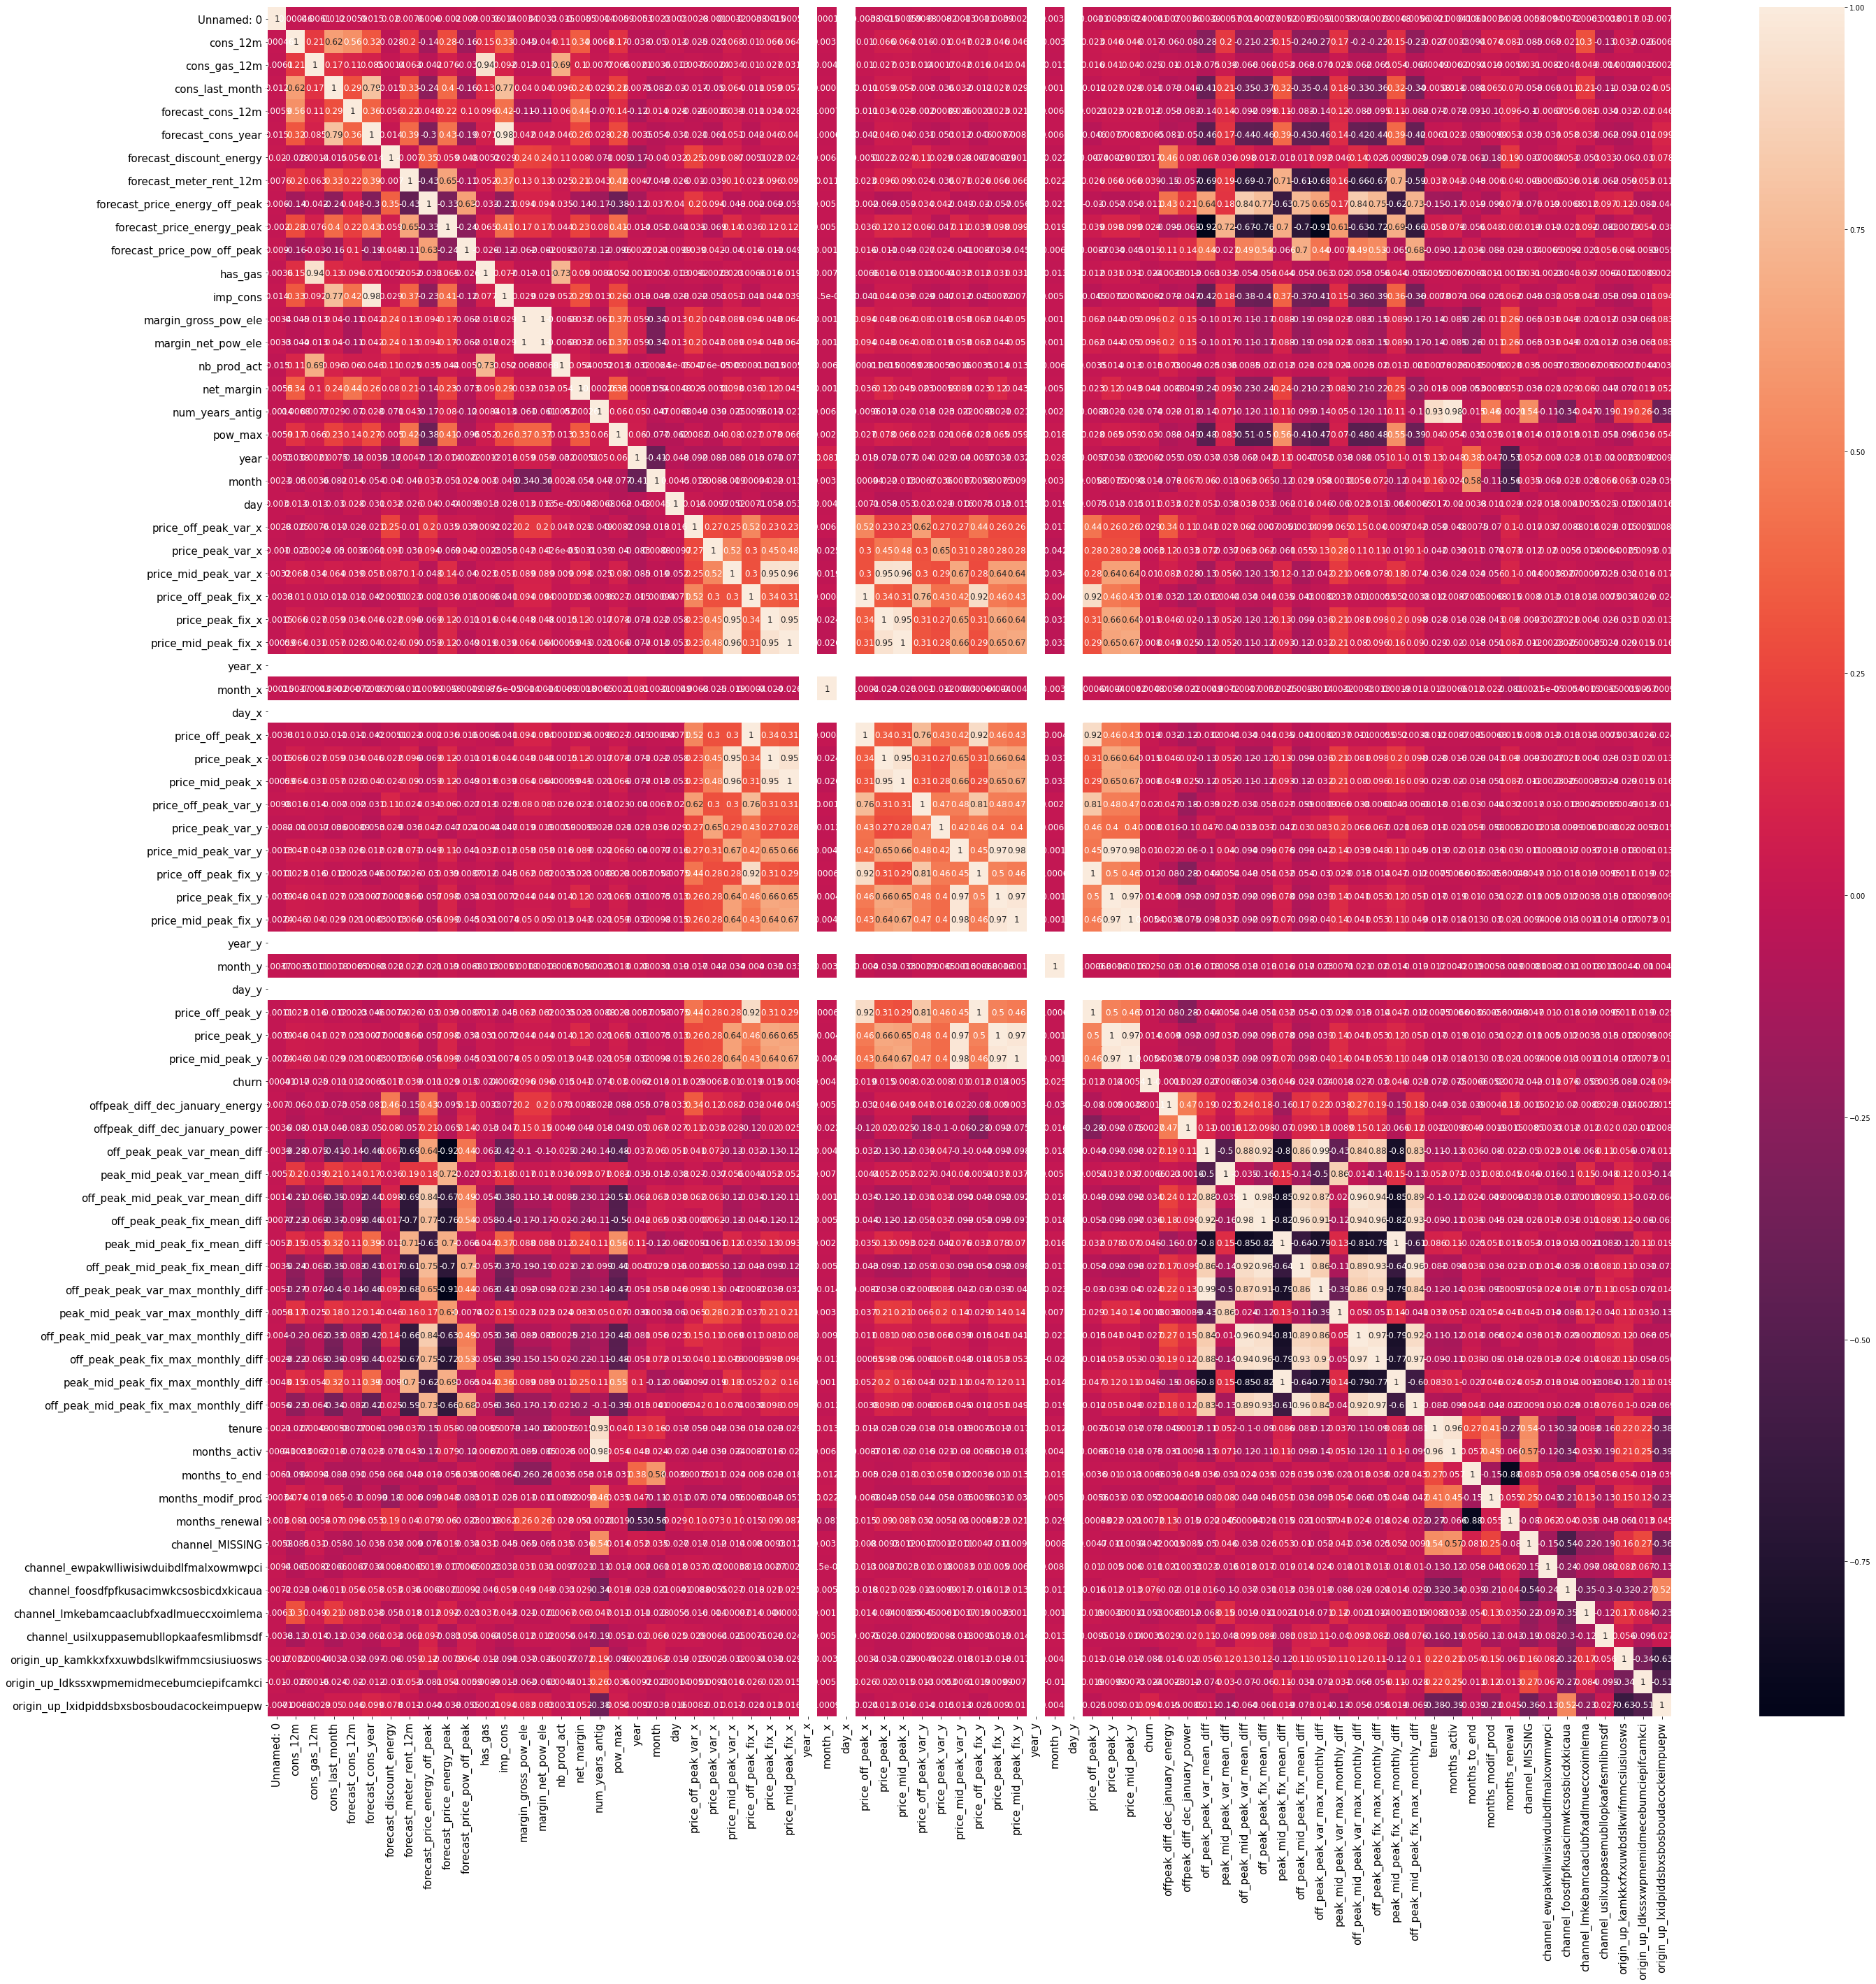

In [27]:
correlation = df.corr()
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
correlation,
xticklabels=correlation.columns.values,
yticklabels=correlation.columns.values,
annot=True,
annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

I will leave it as an exercise for yourself to decide which features to remove based on the correlation
results (there are various methods you can use to decide which features to remove).
For now, I will remove two variables which exhibit a high correlation with other independent
features.

In [28]:
df = df.drop(columns=['num_years_antig', 'forecast_cons_year'])
df.head()

,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,...,2,6,0,0,1,0,0,0,0,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,...,76,4,1,0,0,0,0,1,0,0
2,2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,...,68,8,0,0,1,0,0,1,0,0
3,3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,...,69,9,0,0,0,1,0,1,0,0
4,4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,...,71,9,1,0,0,0,0,1,0,0


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14606 entries, 0 to 14605
Data columns (total 73 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Unnamed: 0                                  14606 non-null  int64  
 1   id                                          14606 non-null  object 
 2   cons_12m                                    14606 non-null  float64
 3   cons_gas_12m                                14606 non-null  float64
 4   cons_last_month                             14606 non-null  float64
 5   forecast_cons_12m                           14606 non-null  float64
 6   forecast_discount_energy                    14606 non-null  float64
 7   forecast_meter_rent_12m                     14606 non-null  float64
 8   forecast_price_energy_off_peak              14606 non-null  float64
 9   forecast_price_energy_peak                  14606 non-null  float64
 10  forecast_p

1.7 5. Modelling
We now have a dataset containing features that we have engineered and we are ready to start
training a predictive model. Remember, we only need to focus on training a Random Forest
classifier.

In [30]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

1.7.1 Data sampling
The first thing we want to do is split our dataset into training and test samples. The reason why
we do this, is so that we can simulate a real life situation by generating predictions for our test
sample, without showing the predictive model these data points. This gives us the ability to see
how well our model is able to generalise to new data, which is critical.
A typical % to dedicate to testing is between 20-30, for this example we will use a 75-25% split
between train and test respectively.

In [31]:
# Make a copy of our data
train_df = df.copy()
# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)


(14606, 71)
(14606,)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 71)
(10954,)
(3652, 71)
(3652,)


1.7.2 Model training
Once again, we are using a Random Forest classifier in this example. A Random Forest sits
within the category of ensemble algorithms because internally the Forest refers to a collection of
Decision Trees which are tree-based learning algorithms. As the data scientist, you can control
how large the forest is (that is, how many decision trees you want to include).
The reason why an ensemble algorithm is powerful is because of the laws of averaging, weak learners
and the central limit theorem. If we take a single decision tree and give it a sample of data and
some parameters, it will learn patterns from the data. It may be overfit or it may be underfit, but
that is now our only hope, that single algorithm.
With ensemble methods, instead of banking on 1 single trained model, we can train 1000’s of
decision trees, all using different splits of the data and learning different patterns. It would be like
asking 1000 people to all learn how to code. You would end up with 1000 people with different
answers, methods and styles! The weak learner notion applies here too, it has been found that if
you train your learners not to overfit, but to learn weak patterns within the data and you have a lot
of these weak learners, together they come together to form a highly predictive pool of knowledge!
This is a real life application of many brains are better than 1.
Now instead of relying on 1 single decision tree for prediction, the random forest puts it to the
overall views of the entire collection of decision trees. Some ensemble algorithms using a voting
approach to decide which prediction is best, others using averaging.
As we increase the number of learners, the idea is that the random forest’s performance should
converge to its best possible solution.
Some additional advantages of the random forest classifier include:
• The random forest uses a rule-based approach instead of a distance calculation and so features
do not need to be scaled
• It is able to handle non-linear parameters better than linear based models
On the flip side, some disadvantages of the random forest classifier include:
• The computational power needed to train a random forest on a large dataset is high, since
we need to build a whole ensemble of estimators.
• Training time can be longer due to the increased complexity and size of thee ensemble

In [33]:
model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

1.7.3 Evaluation
Now let’s evaluate how well this trained model is able to predict the values of the test dataset.
We are going to use 3 metrics to evaluate performance:
• Accuracy = the ratio of correctly predicted observations to the total observations
• Precision = the ability of the classifier to not label a negative sample as positive
• Recall = the ability of the classifier to find all the positive samples
The reason why we are using these three metrics is because a simple accuracy is not always a good
measure to use. To give an example, let’s say you’re predicting heart failures with patients in a
hospital and there were 100 patients out of 1000 that did have a heart failure.
If you predicted 80 out of 100 (80%) of the patients that did have a heart failure correctly, you
might think that you’ve done well! However, this also means that you predicted 20 wrong and
what may the implications of predicting these remaining 20 patients wrong? Maybe they miss out
on getting vital treatment to save their lives.
As well as this, what about the impact of predicting negative cases as positive (people not having
heart failure being predicted that they did), maybe a high number of false positives means that
resources get used up on thee wrong people and a lot of time is wasted when they could have been
helping the real heart failure sufferers.
This is just an example, but it illustrates why other performance metrics are necessary such
Precision and Recall, which are good measures to use in a classification scenario.

In [34]:
predictions = model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()



In [35]:
y_test.value_counts()

0    3286
1     366
Name: churn, dtype: int64

In [36]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")
print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test, predictions)}")
print(f"Recall: {metrics.recall_score(y_test, predictions)}")


True positives: 17
False positives: 3
True negatives: 3283
False negatives: 349

Accuracy: 0.9036144578313253
Precision: 0.85
Recall: 0.04644808743169399


Looking at these results there are a few things to point out:
Note: If you are running this notebook yourself, you may get slightly different answers!
• Within the test set about 10% of the rows are churners (churn = 1).
• Looking at the true negatives, we have 3282 out of 3286. This means that out of all the
negative cases (churn = 0), we predicted 3282 as negative (hence the name True negative).
This is great!
• Looking at the false negatives, this is where we have predicted a client to not churn (churn
= 0) when in fact they did churn (churn = 1). This number is quite high at 348, we want to
get the false negatives to as close to 0 as we can, so this would need to be addressed when
improving the model.
• Looking at false positives, this is where we have predicted a client to churn when they actually
didnt churn. For this value we can see there are 4 cases, which is great!
• With the true positives, we can see that in total we have 366 clients that churned in the test
dataset. However, we are only able to correctly identify 18 of those 366, which is very poor.
• Looking at the accuracy score, this is very misleading! Hence the use of precision and recall
is important. The accuracy score is high, but it does not tell us the whole story.
• Looking at the precision score, this shows us a score of 0.82 which is not bad, but could be
improved.
29
• However, the recall shows us that the classifier has a very poor ability to identify positive
samples. This would be the main concern for improving this model!
So overall, we’re able to very accurately identify clients that do not churn, but we are not able
to predict cases where clients do churn! What we are seeing is that a high % of clients are being
identified as not churning when they should be identified as churning. This in turn tells me that
the current set of features are not discriminative enough to clearly distinguish between churners
and non-churners.
A data scientist at this point would go back to feature engineering to try and create more predictive
features. They may also experiment with optimising the parameters within the model to improve
performance. For now, lets dive into understanding the model a little more.


1.7.4 Model understanding
A simple way of understanding the results of a model is to look at feature importances. Feature
importances indicate the importance of a feature within the predictive model, there are several
ways to calculate feature importance, but with the Random Forest classifier, we’re able to extract
feature importances using the built-in method on the trained model. In the Random Forest case,
the feature importance represents the number of times each feature is used for splitting across all
trees.

In [37]:
 feature_importances = pd.DataFrame({
'features': X_train.columns,
'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

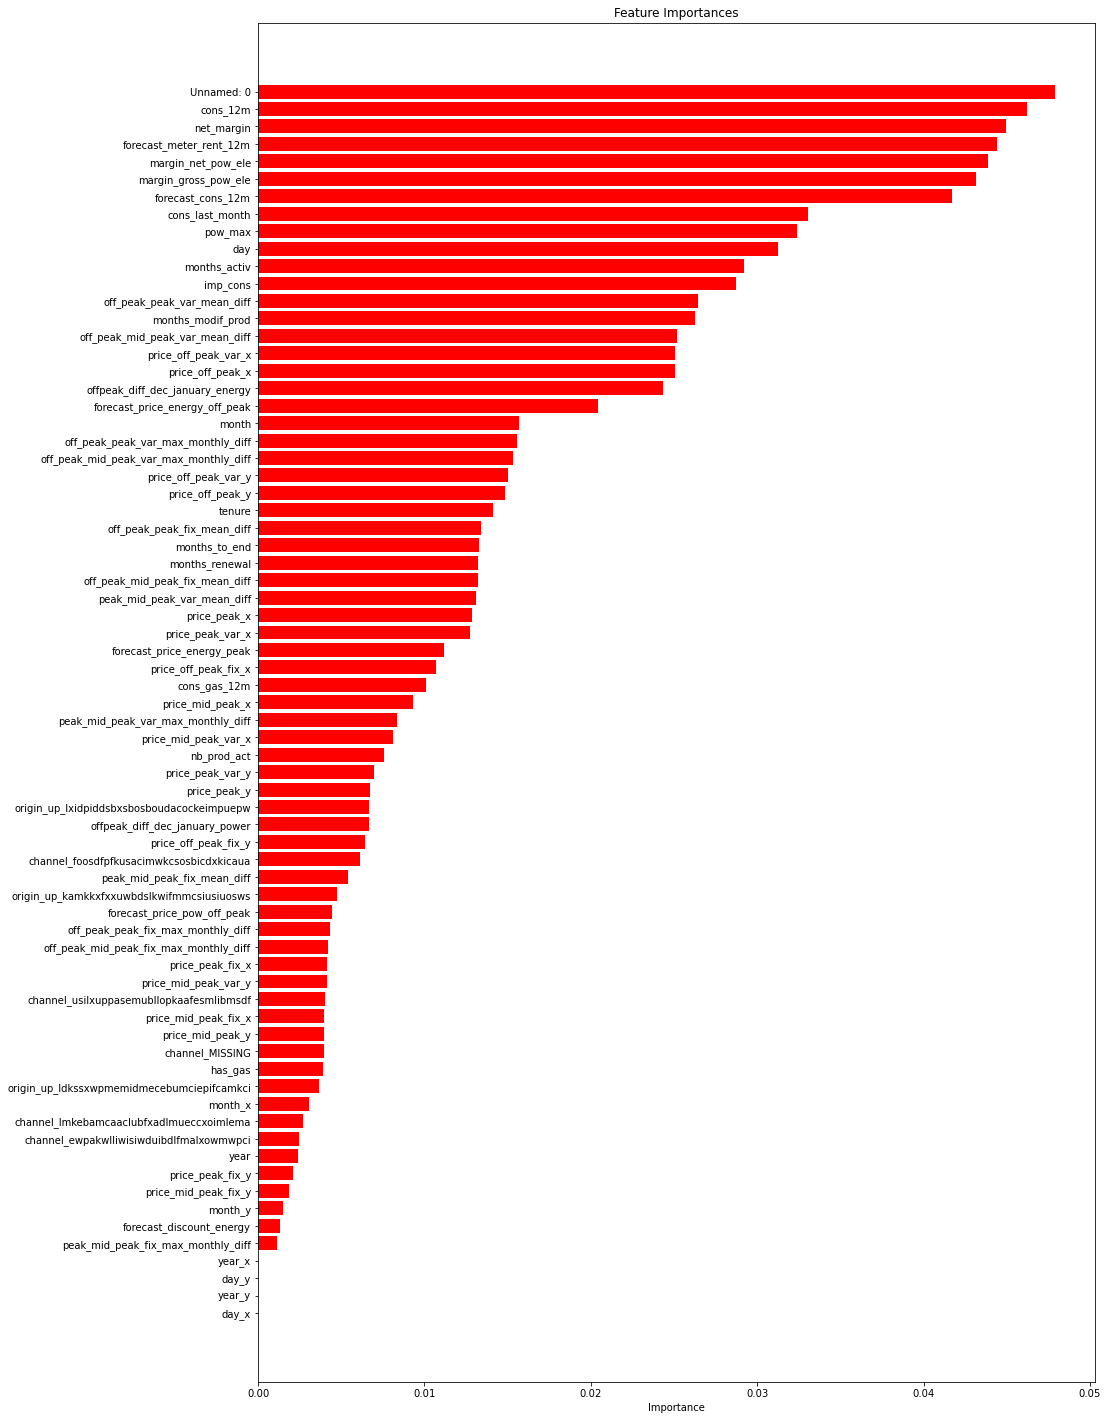

In [42]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'],color='r', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

From this chart, we can observe the following points:
• Net margin and consumption over 12 months is a top driver for churn in this model
• Margin on power subscription also is an influential driver
• Time seems to be an influential factor, especially the number of months they have been active,
their tenure and the number of months since they updated their contract
• The feature that our colleague recommended is in the top half in terms of how influential it
is and some of the features built off the back of this actually outperform it
• Our price sensitivity features are scattered around but are not the main driver for a customer
churning
The last observation is important because this relates back to our original hypothesis:
 Is churn driven by the customers' price sensitivity?
Based on the output of the feature importances, it is not a main driver but it is a weak contributor.
However, to arrive at a conclusive result, more experimentation is needed.

In [39]:
proba_predictions = model.predict_proba(X_test)
probabilities = proba_predictions[:, 1]

In [40]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [41]:
X_test['churn'] = predictions.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('out_of_sample_data_with_predictions.csv')